# Load a trained model and assess performance

In [75]:
import sys
import os
import numpy as np
np.random.seed(42)

import json
import tensorflow as tf

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')


In [6]:
# Directory in which the code sits
git_dir = os.path.join(os.path.expanduser('~'), 'git', 'vae-sld')

config_file = os.path.join(git_dir, 'scripts', 'config-a_si-air.json')
with open(config_file, 'r') as fd:
    config = json.load(fd)

data_dir = config['data_dir']
train_dir = config['train_dir']
model_name = config['name']

# Add source to path
sys.path.append(config['src_dir'])
sys.path.append(os.path.join(config['src_dir'], 'src'))

import reflectivity_model
import network
import importlib
importlib.reload(reflectivity_model)
importlib.reload(network)

<module 'network' from '/Users/m2d/git/vae-sld/src/network.py'>

dict_keys(['loss', 'val_loss'])
Number of epochs: 25


<IPython.core.display.Javascript object>


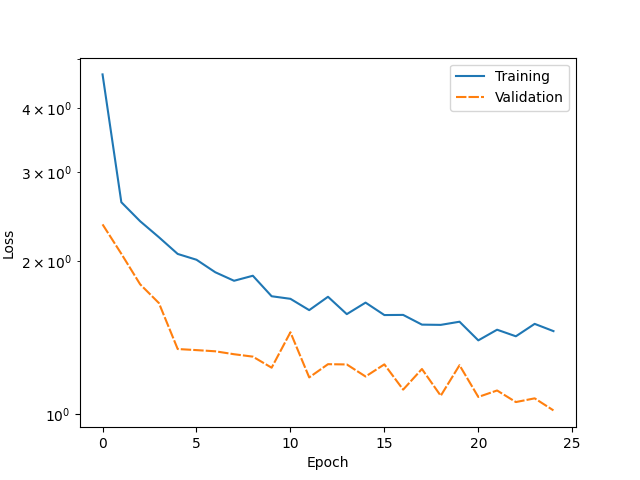

In [229]:
with open(os.path.join(train_dir, "%s_history.json" % model_name), 'r') as fd:
    history = json.load(fd)
    print(history.keys())
    
print("Number of epochs: %g" % len(history['loss']))

linestyle = (0, (5, 1))

fig = plt.figure(dpi=100)
plt.plot(np.arange(len(history['loss'])), history['loss'], label='Training')
plt.plot(np.arange(len(history['val_loss'])), history['val_loss'], label='Validation', linestyle=linestyle)

if 'kl_metric' in history:
    plt.plot(np.arange(len(history['kl_metric'])), history['kl_metric'], label='KL training')
    plt.plot(np.arange(len(history['val_kl_metric'])), history['val_kl_metric'], label='KL validation', linestyle=linestyle)

    plt.plot(np.arange(len(history['nll_metric'])), history['nll_metric'], label='NLL training')
    plt.plot(np.arange(len(history['val_nll_metric'])), history['val_nll_metric'], label='NLL validation', linestyle=linestyle)

    plt.plot(np.arange(len(history['reconstruction_mse_metric'])), history['reconstruction_mse_metric'], label='R training')
    plt.plot(np.arange(len(history['val_reconstruction_mse_metric'])), history['val_reconstruction_mse_metric'], label='R validation', linestyle=linestyle)

#plt.plot(np.arange(len(history['mse_metric'])), history['mse_metric'], label='MSE training')
#plt.plot(np.arange(len(history['val_mse_metric'])), history['val_mse_metric'], label='MSE validation', linestyle=linestyle)

#plt.plot(np.arange(len(history['mono_metric'])), history['mono_metric'], label='Mono training')
#plt.plot(np.arange(len(history['val_mono_metric'])), history['val_mono_metric'], label='Mono validation', linestyle=linestyle)

plt.gca().legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

In [230]:
importlib.reload(reflectivity_model)
importlib.reload(network)

# Load the trained model
model = network.load_model(model_name, train_dir)

# We may use a different config to generate a validation set
with open(config_file, 'r') as fd:
    config_val = json.load(fd)

m = reflectivity_model.ReflectivityModels.from_dict(config_val)
q, test_data, test_pars = m.load(config_val['train_dir'])


# The prediction is the amplitude as [z_mean, z_log_var, z_sampled]
# We must split in three
preds = model.predict(test_data)
print("Predicted SLD: %s" % str(preds.shape))

sld_pred, log_var_pred, sampled = tf.split(preds, 3, axis=1)

d_sld = tf.exp(log_var_pred)
i_test = 1

Dimensions: 150 202
   71/31250 [..............................] - ETA: 1:08

2023-04-06 17:07:35.477715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31250/31250 [==============================] - 53s 2ms/step
Predicted SLD: (1000000, 303)


# Get the training data in R(Q) and retrieve the error

<IPython.core.display.Javascript object>


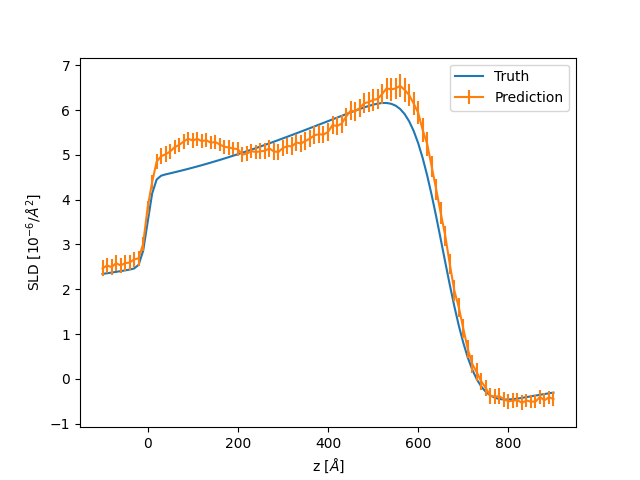

<IPython.core.display.Javascript object>


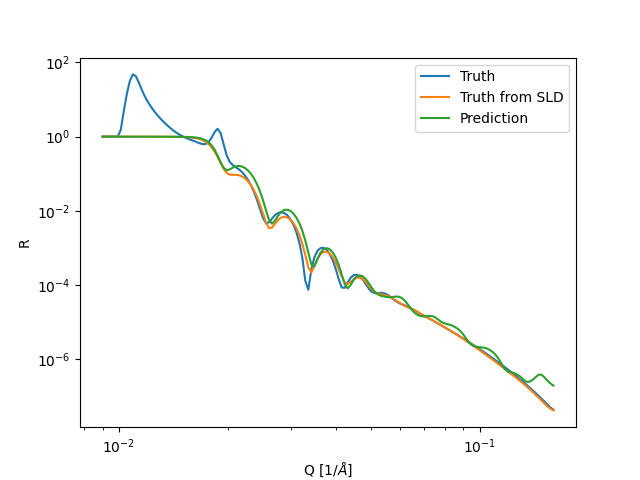

In [241]:
importlib.reload(reflectivity_model)

i_test +=1

z = np.arange(config_val['z_left'], config_val['z_right']+config_val['dz'], config_val['dz'])

#for i in range(20):
#    print("%s %s" % (sld_pred[i_test][i], d_sld[i_test][i]))

fig = plt.figure(dpi=100)
plt.plot(z, test_pars[i_test], label="Truth")
plt.errorbar(z, sld_pred[i_test], yerr=d_sld[i_test], label="Prediction")
#plt.errorbar(z, sampled[i_test], yerr=d_sld[i_test], label="Sampled")
plt.gca().legend()
plt.xlabel('z [$\AA$]')
plt.ylabel('SLD [$10^{-6}/\AA^2$]')
plt.show()

r_true_sld = reflectivity_model.calculate_reflectivity_from_profile(q, z, test_pars[i_test])
r_true = np.power(10, test_data[i_test])*q[0]**2/q**2
r_pred = reflectivity_model.calculate_reflectivity_from_profile(q, z, sld_pred[i_test])
r_pred_sampled = reflectivity_model.calculate_reflectivity_from_profile(q, z, sampled[i_test])

fig = plt.figure(dpi=100)
plt.plot(q, r_true, label="Truth")
plt.plot(q, r_true_sld, label="Truth from SLD")
plt.plot(q, r_pred, label="Prediction")
#plt.plot(q, r_pred_sampled, label="Sampled")
#plt.errorbar(z, sld_pred[i_test], yerr=d_sld[i_test], label="Prediction")
#plt.errorbar(z, sampled[i_test], yerr=d_sld[i_test], label="Sampled")
plt.gca().legend()
plt.xlabel('Q [$1/\AA$]')
plt.ylabel('R')
plt.xscale('log')
plt.yscale('log')
plt.show()



In [223]:
for i in range(len(z)):
    print("%g \t %g \t %g" % (z[i], sld_pred[i_test][i].numpy(), d_sld[i_test][i].numpy()))

-100 	 2.01776 	 0.158968
-90 	 2.10779 	 0.157913
-80 	 2.05903 	 0.158246
-70 	 2.11776 	 0.162008
-60 	 2.07058 	 0.157511
-50 	 2.01436 	 0.1555
-40 	 2.08174 	 0.161274
-30 	 2.09171 	 0.163301
-20 	 2.32649 	 0.159139
-10 	 3.0846 	 0.154481
0 	 4.79711 	 0.18187
10 	 6.57922 	 0.210986
20 	 7.42233 	 0.194045
30 	 7.53129 	 0.182592
40 	 7.64039 	 0.187434
50 	 7.63712 	 0.234059
60 	 7.66383 	 0.196989
70 	 7.71429 	 0.197347
80 	 7.64165 	 0.21279
90 	 7.68584 	 0.224089
100 	 7.61643 	 0.19489
110 	 7.70386 	 0.184255
120 	 7.63564 	 0.177395
130 	 7.69206 	 0.187415
140 	 7.69471 	 0.186907
150 	 7.76457 	 0.194397
160 	 7.73666 	 0.182402
170 	 7.65914 	 0.187367
180 	 7.68119 	 0.183443
190 	 7.61339 	 0.172231
200 	 7.48688 	 0.175954
210 	 7.50116 	 0.200377
220 	 7.52441 	 0.204952
230 	 7.49282 	 0.187907
240 	 7.38064 	 0.175918
250 	 7.31724 	 0.18474
260 	 7.31361 	 0.199539
270 	 7.31995 	 0.161487
280 	 7.2636 	 0.194242
290 	 7.26109 	 0.197515
300 	 7.43387 	 0.